Task is to build a statistical model for predicting the price of a taxi journey based on the coordinates 
of the start/end of the journey, as well as the identity of the taxi driver. Thereby, the evaluation metric for this competition is the Root Mean Square Percentage Error. It is defined as

$$ RMPSE = \sqrt{\frac{1}{N} \sum_{i=1}^N (\frac{p_i - t_i}{p_i})^2} $$

where $p_i$ is the prediction and $t_i$ is the real value for example sample "i". For simplicity, in this competition, you need to predict the PRICE, which is defined as

$$PRICE=DURATION+TRAJLENGTH$$

The underlying script should concentrate on predicting the trajectory length using a local cost optimisation on a street map built from the given data. 

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle

# Read training data into dataframe.
data = pd.read_csv("../data/train_data.csv")

# Delete ID column as it does not contain any information.
data.drop('ID', axis=1, inplace=True)
# As the following code concentrates on predicting the TRAJ_LENGTH which has to 
# be independant on the DURATION (to avoid making one prediction error twice),
# we can remove it as well. 
data.drop('DURATION', axis=1, inplace=True)

# Shuffle data set. 
data = shuffle(data)

data.describe()

,TAXI_ID,X_START,Y_START,X_END,Y_END,TRAJ_LENGTH
count,465172.000000,465172.000000,465172.000000,465172.000000,465172.000000,465172.000000
mean,324.120325,-274.488314,-248.023385,-243.426088,-238.723090,242.227729
std,213.338511,79.726986,76.578983,117.361666,95.057705,149.919004
min,1.000000,-381.000000,-415.000000,-431.000000,-419.000000,21.000000
25%,148.000000,-340.000000,-296.000000,-330.000000,-300.000000,137.000000
50%,298.000000,-296.000000,-272.000000,-267.000000,-263.000000,200.000000
75%,454.000000,-223.000000,-202.000000,-190.000000,-191.000000,303.000000
max,800.000000,-42.000000,-12.000000,426.000000,68.000000,999.000000


In [4]:
import matplotlib.pyplot as plt

def draw_and_save_map(env_map, save_path, path=[], true_path=[], 
                      start=None, start_reset=None, end=None, end_reset=None):
    # Draw and save a street map - array representation. Optionally, a path
    # as well as start and end point can be highlighted. 
    plot_array = copy.copy(env_map)
    for element in path:
        plot_array[element[0], element[1]] = 8
    for element in true_path:
        plot_array[element[0], element[1]] = 4   
    if not start is None and not end is None: 
        plot_array[start[0], start[1]] = 15
        plot_array[end[0],   end[1]]   = 20
    if not start_reset is None and not end_reset is None: 
        plot_array[start_reset[0], start_reset[1]] = 15
        plot_array[end_reset[0],   end_reset[1]]   = 20        
    plot_array = np.transpose(plot_array)
    plot = plt.imshow(plot_array[:, :])
    plt.imsave(save_path, plot_array[:, :])

# Building a Street Map from Data

The streets has to be found to expand the agent from start to end later on, by using the given trajectories. To do so, at first a map with maximal width and height from data is created with all elements set to False, then, whenever a point in the map is found in one of trajectories, it is set to True. The resulting raw street map is filtered afterwards, by applying simple pooling. 

In [5]:
# Get maximal index width of map by searching for maximum and minimum 
# in given data. 
x_min = min(min(data['X_START']), min(data['X_END']))
x_max = max(max(data['X_START']), max(data['X_END']))
y_min = min(min(data['Y_START']), min(data['Y_END']))
y_max = max(max(data['Y_START']), max(data['Y_END']))
for index, row in data.iterrows():
    traj_x = [int(x) for x in row['X_TRAJECTORY'].split(",")]
    x_min  = min(traj_x) if x_min > min(traj_x) else x_min
    x_max  = max(traj_x) if x_max < max(traj_x) else x_max
    traj_y = [int(y) for y in row['Y_TRAJECTORY'].split(",")]
    y_min  = min(traj_y) if y_min > min(traj_y) else y_min
    y_max  = max(traj_y) if y_max < max(traj_y) else y_max
size_x = (x_max - x_min) + 1
size_y = (y_max - y_min) + 1

# Build up "raw" street map by iterating over all trajectories. 
raw_street_map = np.zeros((size_x, size_y), dtype=int)
for index, row in data.iterrows():
    xs       = [int(x) for x in row['X_TRAJECTORY'].split(",")]
    ys       = [int(y) for y in row['Y_TRAJECTORY'].split(",")]
    assert(len(xs) == len(ys)) 
    for traj_index in range(len(xs)):
        x_index = xs[traj_index] - x_min
        y_index = ys[traj_index] - y_min
        raw_street_map[x_index, y_index] += 1

In [5]:
def data_to_map_point(data_point):
    return np.array([data_point[0] - x_min, data_point[1] - y_min])

def data_to_map_path(data_path):
    xs = [int(x) for x in data_path[0].split(",")]
    ys = [int(y) for y in data_path[1].split(",")]
    path = []
    for traj_index in range(len(xs)):
        x_index = xs[traj_index] - x_min
        y_index = ys[traj_index] - y_min
        path.append(np.array([x_index, y_index]))
    return path

def map_to_data_point(map_point):
    return np.array([map_point[0] + x_min, map_point[1] + y_min])

def map_to_data_path(map_path):
    xs = [map_to_data_point(point)[0] for point in map_path]
    ys = [map_to_data_point(point)[1] for point in map_path]
    x_path, y_path = str(xs[0]), str(ys[0])
    for traj_index in range(1, len(xs)):
        x_path += "," + str(xs[traj_index])
        y_path += "," + str(ys[traj_index])
    return x_path, y_path

In [6]:
import copy
from numpy.linalg import norm
from itertools import product
import queue

class MapPoint: 
# Street map element class providing position and boolean access 
# and comfort functions for neighbours, distance, etc. 
    x, y    = 0, 0
    env_map = None

    def __init__(self, x, y, cost=0):
        # Initialise variables at given position. 
        self.x, self.y = x, y
        self.cost = cost
    
    def __eq__(self, other): 
        # Map Point equality operator (same points). 
        return self.x == other.x and self.y == other.y
    
    def __gt__(self, other): 
        return self.cost > other.cost
    
    def neighbours(self):
        # Get neighbours as MapPoints in street map (taking care of edges).
        neighbours = []
        for d in product(*[[-1,0,+1], [-1,0,+1]]):
            if d == [0, 0]  : continue
            neigh = MapPoint(self.x + d[0], self.y + d[1])
            if neigh.valid(): neighbours.append(neigh)
        return neighbours
    
    def valid(self): 
        # Check if map point within borders of street map. 
        (x_max, y_max) = np.shape(self.env_map)
        return 0 <= self.x < x_max and 0 <= self.y < y_max

    def distance(self, to_point): 
        # Calculate and return distance from self to other point.
        # @param[in]     to_point       2D point as np.array([x, y]).
        return norm(self.point - to_point)
    
    # 2D - Point [x,y] property.
    def __get_point(self):
        return np.array([self.x, self.y])
    def __set_point(self, set_point):
        self.x, self.y = set_point[0], set_point[1]
    point = property(__get_point, __set_point)
    
    # Boolean (street map value) property. 
    def __get_boolean(self): 
        return MapPoint.env_map[self.x, self.y]
    def __set_boolean(self, set_boolean): 
        raise NotImplementedError
    boolean = property(__get_boolean, __set_boolean)
    
    # Density = number of street point neighs property. 
    def __get_density(self):
        street_points = 0
        for neigh in self.neighbours():
            if neigh.boolean: street_points += 1
        return street_points
    def __set_density(self, set_density): 
        raise NotImplementedError
    density = property(__get_density, __set_density)

In [7]:
# Applying multiple hit filter to raw street map. 
street_map = np.zeros((size_x, size_y), dtype=int)
for x in range(size_x-1):
    for y in range(size_y-1):
        if raw_street_map[x,y] >= 150: 
            street_map[x, y] = 1

In [8]:
# Applying pooling filter to resulting street map. 
buffer_street_map = copy.copy(street_map)
street_map = np.zeros((size_x, size_y), dtype=int)
MapPoint.env_map = buffer_street_map
for x in range(size_x-1):
    for y in range(size_y-1):
        point = MapPoint(x, y)
        if point.density >= 3 and point.boolean: 
            street_map[x, y] = 1

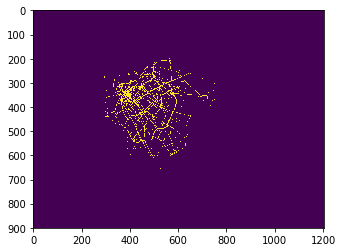

In [9]:
draw_and_save_map(street_map, '../imgs/street_map.png')

In [10]:
# Clean up local variables. 
del raw_street_map, buffer_street_map

# Path Finder by local Optimisation method
To predict the path from a given start to end point a local (inverse) hill climbing algorithm is used. Here, after resetting start and end points to the closest street point, for every step the neighbours costs of the current path point are evaluated so that the path can continue in lowest cost direction. Thereby, the cost function involves the distance to the end point, the continuity of movement direction and the street map (penalisation of being outside of streets). 

In [11]:
import queue

MapPoint.env_map = street_map
def closest_street_point(start_point):
    # Get closest street point in given street map (UCS with goal = true node).
    # @param[in]    start_point 2D point in environment np.array([x, y]).
    start = MapPoint(start_point[0], start_point[1])
    if start.boolean: return start.point, 0
    # Else use UCS to find closest node.
    ucs_queue   = queue.PriorityQueue()
    ucs_queue.put(start)
    visited = np.zeros(np.shape(MapPoint.env_map), dtype=bool)
    visited[start.x, start.y] = True
    while(not ucs_queue.empty()):
        point = ucs_queue.get()
        if point.boolean: return point.point, np.linalg.norm(point.point - start_point)
        for neigh_point in point.neighbours(): 
            if visited[neigh_point.x, neigh_point.y]: continue
            visited[neigh_point.x, neigh_point.y] = True
            neigh_point.cost = neigh_point.distance(start.point)
            ucs_queue.put(neigh_point)
    print("Failed to find closest street point!")
    return start_point, 0

def predict_path(start, end, step_width=5, termination_dis=10, weights=[1, 2, 1]): 
    # Predict the trajectory length from start to end point, 
    # given a street map, i.e. a matrix of costs at any point
    # of predictable space. Thus, we look for the path going 
    # to minimizing direction in  every step (Inverse-Hill-Climbing).
    # @param[in]    start               starting point of path. 
    # @param[in]    end                 ending point of path.
    # @param[in]    step_width          square distance in one iteration. 
    # @param[in]    termination_dis     distance to end point to terminate path finding. 
    # @param[in]    weights             weights for optimisation function 
    #                                   [distance, density, direction].
    # Get closest street point for start and end. 
    start, start_reset_dis = closest_street_point(start)
    start_point = MapPoint(start[0], start[1])
    end, end_reset_dis = closest_street_point(end)
    end_point = MapPoint(end[0], end[1])
    traj_length = start_reset_dis + end_reset_dis
    # Move into direction of highest density. 
    current     = start_point
    path_points = [current.point]
    direction   = np.array([0, 0])
    for step in range(200):
        # Break loop when end point is in range. 
        if current.distance(end_point.point) < termination_dis: break
        # Find minimal value of optimisation function in 
        # neighbour cells (i.e. min distance and max density).
        # Calculate neighbour square around current cell. 
        candidates = []
        for phi in range(0, 360, 2): 
            phi_rad = 180/np.pi*phi
            dx = int(step_width*np.cos(phi_rad))
            dy = int(step_width*np.sin(phi_rad))
            circle_point = MapPoint(current.x + dx, current.y + dy)
            if circle_point.valid(): candidates.append(copy.copy(circle_point))
        # For every candidate determine optimisation function value 
        # and choose candidate with smallest value. 
        best_point = candidates[0]
        best_value = 9999
        for cand in candidates: 
            # Cost calculation for candidate.
            cand_value = + weights[0]*cand.distance(end) \
                         - weights[1]*cand.density \
                         - weights[2]*np.dot((cand.point - current.point), direction)
            # Check if neighbour candidate exceed current best value. 
            if cand_value < best_value: 
                best_point = cand
                best_value = cand_value
        # Set next point to best candidate, iterate costs, 
        # append to trajaectory points and update direction. 
        current  = best_point
        path_points.append(current.point)
        direction   = current.point - path_points[-2]
        traj_length+= np.linalg.norm(current.point - path_points[-2])
        # Check for repetition actions in the paths end. If the path is repeated in the last k 
        # elements the search breaks and the remaining distance is approximated by euclidian distance. 
        last_path = path_points[-5:-2]
        for last_point in last_path: 
            if current.distance(last_point) < step_width/2: 
                part_of_distance = current.distance(end)/np.linalg.norm(start-end)
                traj_length += current.distance(end)
                path_points.append(end_point.point)
                return path_points, traj_length, start, end
    # Add end point and termination distance to path length and return. 
    path_points.append(end_point.point)
    traj_length += termination_dis
    return path_points, traj_length, start, end

# Evaluation 
Determine average error (in relation to groundtruth from data) and compare to error of euclidian distance between start and end point. 

In [12]:
import time

pred_errors, euclidian_errors = [], []
step_width = 5
weights    = [1.0,1.6,0.2]

samples = data.sample(n=40)
start_time = time.time()
for index, sample in samples.iterrows():
    # Get start and end point from data sample. 
    start  = data_to_map_point(np.array([sample['X_START'], sample['Y_START']]))
    end    = data_to_map_point(np.array([sample['X_END'],   sample['Y_END']]))
    # Predict path. 
    path, prediction, rstart, rend = predict_path(start, end, step_width=step_width, weights=weights)
    # Determine prediction and euclidian error.
    groundtruth = sample['TRAJ_LENGTH']
    euclidian   = np.linalg.norm(start - end)
    pred_errors.append(abs(prediction - groundtruth)/groundtruth)
    euclidian_errors.append(abs(euclidian - groundtruth)/groundtruth)
    # Draw prediction and true path in one map.
    if pred_errors[-1] > 1.0:
        print("Really bad error occured: %f with abs %f" % (pred_errors[-1], abs(prediction - groundtruth)))
        true_path = data_to_map_path((sample['X_TRAJECTORY'], sample['Y_TRAJECTORY']))
        problem_image_name = "../imgs/path_map" + str(index) + ".png"
        draw_and_save_map(street_map, problem_image_name, path=path, true_path=true_path, \
                          start=start, start_reset=rstart, end=end, end_reset=rend)

print("Road Map Prediction vs Euclidian Distance prediction over %d samples" % len(pred_errors))
print("Mean:   %f vs. %f" % (np.mean(pred_errors), np.mean(euclidian_errors)))
print("Median: %f vs. %f" % (np.median(pred_errors), np.median(euclidian_errors)))
print("Time need for %d samples is %f seconds" % (len(pred_errors), time.time() - start_time))

Road Map Prediction vs Euclidian Distance prediction over 40 samples
Mean:   0.203826 vs. 0.332362
Median: 0.165043 vs. 0.296221
Time need for 40 samples is 21.658936 seconds


# Prediction 
Predict the trajectory length for given set of test data (test.csv) and write results into output txt file.

In [13]:
def predict_data_sample(x_start, y_start, x_end, y_end, step_width=20, weights=[1.0,1.6,0.2]): 
    # Predict trajectory length of data sample as it is given in absolute 
    # coordinates (i.e. non map) in the dataset (training and test). 
    start  = data_to_map_point(np.array([x_start, y_start]))
    end    = data_to_map_point(np.array([x_end,   y_end]))
    # Predict path. 
    path, prediction, _, _ = predict_path(start, end, step_width=step_width, weights=weights)
    x_path, y_path = map_to_data_path(path)
    return prediction, x_path, y_path

In [ ]:
from tqdm import tqdm_notebook

test = pd.read_csv("../data/test.csv")
pbar = tqdm_notebook(total=test.shape[0])

for index, row in test.iterrows():
    pbar.update(1)
    prediction, x_path, y_path = predict_data_sample(row['X_START'], row['Y_START'], 
                                                     row['X_END'],   row['Y_END'])
    test.at[(index, 'TRAJ_LENGTH')] = prediction
    test.at[(index, 'X_PATH')]      = x_path
    test.at[(index, 'Y_PATH')]      = y_path

test.to_csv("../predictions/road_map.csv")
pbar.close()
test.head()